In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
# torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
# from AttentiveFP.get_atom_bond_features_0_0612 import save_smiles_dicts, get_smiles_dicts, get_smiles_array

from get_atom_bond_features_with_bond_len_ediff_with_frag_0515 import save_smiles_dicts, get_smiles_dicts, get_smiles_array



No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with transformers dependency. No module named 'transformers'
cannot import name 'HuggingFaceModel' from 'deepchem.models.torch_models' (/root/miniconda3/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/root/miniconda3/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loa

In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score

In [3]:
# from rdkit.Chem import rdMolDescriptors, MolSurf
# from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
from IPython.display import SVG, display
import seaborn as sns; sns.set(color_codes=True)

In [4]:
from config import cfg

number of all smiles:  1513
remained_smiles:  1513
number of successfully processed smiles:  1513
number of successfully processed smiles:  1513
canonical_smiles_list:  1513
new_smilesList:  1513
normal_2_standard:  1513


/tmp/ipykernel_5531/669472425.py:37: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax = sns.distplot(atom_num_dist, bins=28, kde=False)


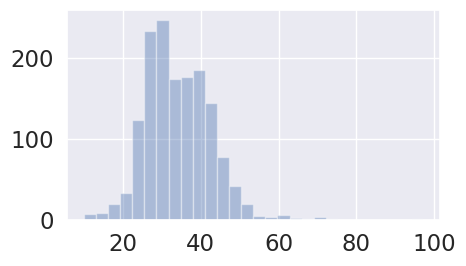

In [5]:
task_name = cfg.task_name
tasks = cfg.tasks###哪些标签
raw_filename = cfg.data_raw_filename###数据存放地址
feature_filename = raw_filename.replace('.csv','.pickle')####
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
new_smilesList = []
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
normal_2_standard = {}

for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
        new_smilesList.append(smiles)
        normal_2_standard[smiles] = Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True)
    except:
        print("not successfully processed smiles: ", smiles)
        pass
print("remained_smiles: ",len(remained_smiles))
print("number of successfully processed smiles: ", len(remained_smiles))
print("number of successfully processed smiles: ", len(remained_smiles))
print("canonical_smiles_list: ",len(canonical_smiles_list))
print("new_smilesList: ",len(new_smilesList))
print("normal_2_standard: ",len(normal_2_standard))


plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()


In [6]:
len(canonical_smiles_list)

1513

In [7]:
len(set(canonical_smiles_list))

1513

In [8]:
len(normal_2_standard.keys())

1513

In [9]:
len(new_smilesList)

1513

In [10]:
len(set(new_smilesList))###########对bbbp原始的smiles进行去重

1513

In [11]:
len(smilesList)

1513

In [12]:
from collections import defaultdict

def create_value_to_keys_dict(original_dict):
    value_to_keys = defaultdict(list)
    
    # 遍历原字典，将值作为键，原键作为值添加到新字典
    for key, value in original_dict.items():
        value_to_keys[value].append(key)
    
    # 只保留有重复值的项
    result = {value: keys for value, keys in value_to_keys.items() if len(keys) > 1}
    
    return result

In [13]:
repeat_smiles_dict= create_value_to_keys_dict(normal_2_standard)

In [14]:
repeat_smiles_dict

{}

In [15]:
len(repeat_smiles_dict)

0

In [16]:
for key, value in repeat_smiles_dict.items():
    if len(value)>1:
        print(value)

In [17]:
count_ = 0
anomaly_keys = []
anomaly_values = []
repeat_normal_smiles = []

for keys,values_list in repeat_smiles_dict.items():
    count_ += 1
    value2bbbp = []
    
    for ii in values_list:
        # print(ii)
        value2bbbp.append(smiles_tasks_df.loc[smiles_tasks_df['smiles'] == ii, 'BBBP'].values[0])
    
    if len(set(value2bbbp)) > 1:
        anomaly_keys.append(keys)
        anomaly_values.extend(values_list)
    
    if len(set(value2bbbp)) == 1:
        repeat_normal_smiles.extend(values_list[1:])
    
    print(value2bbbp)
    print(count_)
    print(keys)

In [18]:
anomaly_keys

[]

In [19]:
anomaly_values

[]

In [20]:
def remove_elements(large_list, small_list):
    # 将小列表转换为集合，提高查找效率
    remove_set = set(small_list)
    
    # 使用列表推导式生成新列表
    return [item for item in large_list if item not in remove_set]

In [21]:
new_smilesList = remove_elements(new_smilesList,anomaly_values)###这个肯定要去掉的
new_smilesList = remove_elements(new_smilesList,repeat_normal_smiles)###这个去不去掉，随机划分不用去，scffold还是去掉；

In [22]:
len(new_smilesList)

1513

In [23]:
new_smilesList = [smiles for smiles in new_smilesList if len(Chem.MolFromSmiles(smiles).GetAtoms())<101]
len(new_smilesList)

1513

In [24]:
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(new_smilesList)]

print(smiles_tasks_df)


                                                 smiles        CID  Class  \
0     O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...     BACE_1      1   
1     Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...     BACE_2      1   
2     S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...     BACE_3      1   
3     S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...     BACE_4      1   
4     S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...     BACE_5      1   
...                                                 ...        ...    ...   
1508          Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N  BACE_1543      0   
1509          Clc1cc2nc(n(c2cc1)C(CC(=O)NCc1ncccc1)CC)N  BACE_1544      0   
1510             Brc1cc(ccc1)C1CC1C=1N=C(N)N(C)C(=O)C=1  BACE_1545      0   
1511       O=C1N(C)C(=NC(=C1)C1CC1c1cc(ccc1)-c1ccccc1)N  BACE_1546      0   
1512                Clc1cc2nc(n(c2cc1)CCCC(=O)NCC1CC1)N  BACE_1547      0   

      Model     pIC50         MW   AlogP  HBA  HBD  RB  ...  PEOE6 (PEOE6) 

In [25]:
normal_smilesList = smiles_tasks_df.smiles.values
canonical_smiles_new_list = []
for smile in normal_smilesList:
    canonical_smiles_new_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smile), isomericSmiles=True))
# smiles_tasks_df['cano_smiles'] =canonical_smiles_new_list
smiles_tasks_df.loc[:, 'cano_smiles'] = canonical_smiles_new_list

In [26]:
type(normal_smilesList)

numpy.ndarray

In [27]:
type(new_smilesList)

list

In [28]:
smiles_tasks_df

,smiles,CID,Class,Model,pIC50,MW,AlogP,HBA,HBD,RB,...,PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14),canvasUID,cano_smiles
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901,431.56979,4.4014,3,2,5,...,78.640335,226.855410,107.434910,37.133846,0.000000,7.980170,0.000000,0.000000,1,Cc1ccccc1-c1ccc2nc(N)c(C[C@@H](C)C(=O)N[C@@H]3...
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872,657.81073,2.6412,5,4,16,...,47.171600,365.676940,174.076750,34.923889,7.980170,24.148668,0.000000,24.663788,2,CCCO[C@H]1C[NH2+][C@@H]([C@@H](O)[C@H](Cc2cc(F...
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970,591.74091,2.5499,4,3,11,...,47.941147,192.406520,255.752550,23.654478,0.230159,15.879790,0.000000,24.663788,3,CCc1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](O)C...
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970,591.67828,3.1680,4,3,12,...,37.954151,194.353040,202.763350,36.498634,0.980913,8.188327,0.000000,26.385181,4,CCOC[C@@H](Oc1cc(C[C@@H]2CS(=O)(=O)C[C@H]([NH2...
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970,629.71283,3.5086,3,3,11,...,39.361153,179.712880,220.461300,23.654478,0.230159,15.879790,0.000000,26.100143,5,CCc1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](O)C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N,BACE_1543,0,Test,3.000000,364.86969,2.5942,3,2,6,...,37.681076,180.226410,95.670128,30.107586,9.368159,7.980170,0.000000,0.000000,1543,CCC(CC(=O)NCC1CCOCC1)n1c(N)nc2cc(Cl)ccc21
1509,Clc1cc2nc(n(c2cc1)C(CC(=O)NCc1ncccc1)CC)N,BACE_1544,0,Test,3.000000,357.83731,2.8229,3,2,6,...,47.349350,122.401500,99.877144,30.107586,9.368159,7.980170,0.000000,0.000000,1544,CCC(CC(=O)NCc1ccccn1)n1c(N)nc2cc(Cl)ccc21
1510,Brc1cc(ccc1)C1CC1C=1N=C(N)N(C)C(=O)C=1,BACE_1545,0,Test,2.953115,320.18451,3.0895,2,1,2,...,22.563574,96.290794,58.798935,20.071724,9.368159,0.000000,6.904104,0.000000,1545,Cn1c(N)nc(C2CC2c2cccc(Br)c2)cc1=O
1511,O=C1N(C)C(=NC(=C1)C1CC1c1cc(ccc1)-c1ccccc1)N,BACE_1546,0,Test,2.733298,317.38440,3.8595,2,1,3,...,9.316234,95.907784,112.609720,20.071724,9.368159,0.000000,6.904104,0.000000,1546,Cn1c(N)nc(C2CC2c2cccc(-c3ccccc3)c2)cc1=O


In [29]:
smiles_tasks_df['smiles'][0]

'O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2ccccc2C)C)CC1(C)C'

In [30]:
smiles_tasks_df['smiles'].iloc[1221]

'S(=O)(=O)(n1cc(c2c1cccc2)C(=O)NC(Cc1ccccc1)C(O)C[NH2+]Cc1cc(OC)ccc1)CCCC'

In [33]:
import deepchem as dc

In [34]:
descriptor = dc.feat.RDKitDescriptors(is_normalized=True)
new_canonical_smiles_new_list=[]

i_count = 0
for smiles in canonical_smiles_new_list:
    features = descriptor.featurize([smiles])[0]
        # print(features)
    if np.isnan(features).any():
        print(f"!!! 发现 NaN，出问题的 SMILES 是: {smiles}")
        continue
    else:
        i_count+=1
        # print((i_count))
        new_canonical_smiles_new_list.append(smiles)

No normalization for SPS. Feature removed!
No normalization for BCUT2D_MWHI. Feature removed!
No normalization for BCUT2D_MWLOW. Feature removed!
No normalization for BCUT2D_CHGHI. Feature removed!
No normalization for BCUT2D_CHGLO. Feature removed!
No normalization for BCUT2D_LOGPHI. Feature removed!
No normalization for BCUT2D_LOGPLOW. Feature removed!
No normalization for BCUT2D_MRHI. Feature removed!
No normalization for BCUT2D_MRLOW. Feature removed!
No normalization for AvgIpc. Feature removed!


In [35]:
len(canonical_smiles_new_list)

1513

In [36]:
len(new_canonical_smiles_new_list)

1513

In [37]:
canonical_smiles_new_list = new_canonical_smiles_new_list

In [38]:
pickle.dump(canonical_smiles_new_list,open('canonical_smiles_new_list'+'.pickle',"wb"))

In [1]:
k
feature_dicts = save_smiles_dicts(canonical_smiles_new_list,filename)######attentivefp，传的是普通smiles；
# feature_dicts = get_smiles_dicts(new_smilesList)
# feature_dicts = save_smiles_dicts(new_smilesList,filename)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]

remained_df = remained_df.reset_index(drop=True)
assert remained_df['cano_smiles'][999]==Chem.MolToSmiles(Chem.MolFromSmiles(remained_df['smiles'][999]), isomericSmiles=True)

df_filename = filename + '_remained_df'
pickle.dump(remained_df,open(df_filename+'.pickle',"wb"))

NameError: name 'k' is not defined

In [5]:
remained_df_filename = "./data/" + cfg.task_name + "_remained_df.pickle"
remained_df = pickle.load(open(remained_df_filename, "rb"))

In [6]:
remained_df

,smiles,CID,Class,Model,pIC50,MW,AlogP,HBA,HBD,RB,...,PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14),canvasUID,cano_smiles
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901,431.56979,4.4014,3,2,5,...,78.640335,226.855410,107.434910,37.133846,0.000000,7.980170,0.000000,0.000000,1,Cc1ccccc1-c1ccc2nc(N)c(C[C@@H](C)C(=O)N[C@@H]3...
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872,657.81073,2.6412,5,4,16,...,47.171600,365.676940,174.076750,34.923889,7.980170,24.148668,0.000000,24.663788,2,CCCO[C@H]1C[NH2+][C@@H]([C@@H](O)[C@H](Cc2cc(F...
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970,591.74091,2.5499,4,3,11,...,47.941147,192.406520,255.752550,23.654478,0.230159,15.879790,0.000000,24.663788,3,CCc1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](O)C...
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970,591.67828,3.1680,4,3,12,...,37.954151,194.353040,202.763350,36.498634,0.980913,8.188327,0.000000,26.385181,4,CCOC[C@@H](Oc1cc(C[C@@H]2CS(=O)(=O)C[C@H]([NH2...
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970,629.71283,3.5086,3,3,11,...,39.361153,179.712880,220.461300,23.654478,0.230159,15.879790,0.000000,26.100143,5,CCc1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](O)C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N,BACE_1543,0,Test,3.000000,364.86969,2.5942,3,2,6,...,37.681076,180.226410,95.670128,30.107586,9.368159,7.980170,0.000000,0.000000,1543,CCC(CC(=O)NCC1CCOCC1)n1c(N)nc2cc(Cl)ccc21
1509,Clc1cc2nc(n(c2cc1)C(CC(=O)NCc1ncccc1)CC)N,BACE_1544,0,Test,3.000000,357.83731,2.8229,3,2,6,...,47.349350,122.401500,99.877144,30.107586,9.368159,7.980170,0.000000,0.000000,1544,CCC(CC(=O)NCc1ccccn1)n1c(N)nc2cc(Cl)ccc21
1510,Brc1cc(ccc1)C1CC1C=1N=C(N)N(C)C(=O)C=1,BACE_1545,0,Test,2.953115,320.18451,3.0895,2,1,2,...,22.563574,96.290794,58.798935,20.071724,9.368159,0.000000,6.904104,0.000000,1545,Cn1c(N)nc(C2CC2c2cccc(Br)c2)cc1=O
1511,O=C1N(C)C(=NC(=C1)C1CC1c1cc(ccc1)-c1ccccc1)N,BACE_1546,0,Test,2.733298,317.38440,3.8595,2,1,3,...,9.316234,95.907784,112.609720,20.071724,9.368159,0.000000,6.904104,0.000000,1546,Cn1c(N)nc(C2CC2c2cccc(-c3ccccc3)c2)cc1=O


In [34]:
feature_filename = "./data/" + cfg.task_name + ".pickle"
feature_dicts = pickle.load(open(feature_filename, "rb"))

In [35]:
feature_dicts.keys()

dict_keys(['smiles_to_frag_mask', 'smiles_to_frag_info', 'smiles_to_frag_atom_bond_incices', 'smiles_to_atom_mask', 'smiles_to_bond_mask', 'smiles_to_atom_info', 'smiles_to_bond_info', 'smiles_to_atom_neighbors_atom', 'smiles_to_atom_neighbors_bond', 'smiles_to_bond_neighbors_bond', 'smiles_to_bond_neighbors_atom', 'smiles_to_rdkit_atom_list', 'smiles_to_rdkit_bond_list', 'smiles_to_descriptor'])

In [37]:
len(feature_dicts['smiles_to_frag_mask'].keys())

1513

In [7]:
remained_df

,smiles,CID,Class,Model,pIC50,MW,AlogP,HBA,HBD,RB,...,PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14),canvasUID,cano_smiles
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901,431.56979,4.4014,3,2,5,...,78.640335,226.855410,107.434910,37.133846,0.000000,7.980170,0.000000,0.000000,1,Cc1ccccc1-c1ccc2nc(N)c(C[C@@H](C)C(=O)N[C@@H]3...
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872,657.81073,2.6412,5,4,16,...,47.171600,365.676940,174.076750,34.923889,7.980170,24.148668,0.000000,24.663788,2,CCCO[C@H]1C[NH2+][C@@H]([C@@H](O)[C@H](Cc2cc(F...
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970,591.74091,2.5499,4,3,11,...,47.941147,192.406520,255.752550,23.654478,0.230159,15.879790,0.000000,24.663788,3,CCc1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](O)C...
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970,591.67828,3.1680,4,3,12,...,37.954151,194.353040,202.763350,36.498634,0.980913,8.188327,0.000000,26.385181,4,CCOC[C@@H](Oc1cc(C[C@@H]2CS(=O)(=O)C[C@H]([NH2...
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970,629.71283,3.5086,3,3,11,...,39.361153,179.712880,220.461300,23.654478,0.230159,15.879790,0.000000,26.100143,5,CCc1cn2c3c(cc(C(=O)N[C@@H](Cc4ccccc4)[C@H](O)C...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1508,Clc1cc2nc(n(c2cc1)C(CC(=O)NCC1CCOCC1)CC)N,BACE_1543,0,Test,3.000000,364.86969,2.5942,3,2,6,...,37.681076,180.226410,95.670128,30.107586,9.368159,7.980170,0.000000,0.000000,1543,CCC(CC(=O)NCC1CCOCC1)n1c(N)nc2cc(Cl)ccc21
1509,Clc1cc2nc(n(c2cc1)C(CC(=O)NCc1ncccc1)CC)N,BACE_1544,0,Test,3.000000,357.83731,2.8229,3,2,6,...,47.349350,122.401500,99.877144,30.107586,9.368159,7.980170,0.000000,0.000000,1544,CCC(CC(=O)NCc1ccccn1)n1c(N)nc2cc(Cl)ccc21
1510,Brc1cc(ccc1)C1CC1C=1N=C(N)N(C)C(=O)C=1,BACE_1545,0,Test,2.953115,320.18451,3.0895,2,1,2,...,22.563574,96.290794,58.798935,20.071724,9.368159,0.000000,6.904104,0.000000,1545,Cn1c(N)nc(C2CC2c2cccc(Br)c2)cc1=O
1511,O=C1N(C)C(=NC(=C1)C1CC1c1cc(ccc1)-c1ccccc1)N,BACE_1546,0,Test,2.733298,317.38440,3.8595,2,1,3,...,9.316234,95.907784,112.609720,20.071724,9.368159,0.000000,6.904104,0.000000,1546,Cn1c(N)nc(C2CC2c2cccc(-c3ccccc3)c2)cc1=O


In [8]:
del remained_df['smiles']
remained_df = remained_df.rename(columns={'cano_smiles': 'mol'})
# remained_df = remained_df.rename(columns={'cano_smiles': 'smiles'})
# cf = cf.rename(columns={'BBBP': 'p_np'})
# print(cf)
remained_df.to_csv("smiles.csv")